In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('../data/1e7datasetcorr.csv', index_col=0)
df.tail()

,Stable,Norbits_instability,Norbits,Mplanet,RH/a,a1,P1,e1,pomega1,inc1,...,Omega3,f3,x3,y3,z3,vx3,vy3,vz3,Rel_Eerr,integ_time
Sim_ID,,,,,,,,,,,,,,,,,,,,,
4995,True,1.000000e+07,10000000.0,0.000015,0.021544,0.053729,0.012454,0.005642,-1.657512,0.012805,...,-2.455928,-0.162476,0.008390,-0.073445,0.000225,23.145675,2.707954,0.045366,2.622256e-09,1437.494908
4996,True,1.000000e+07,10000000.0,0.000015,0.021544,0.056524,0.013439,0.003143,0.454508,0.016073,...,2.849398,1.906923,-0.025937,0.072181,-0.000593,-21.424946,-7.242948,0.126097,1.469989e-08,1502.892072
4997,True,1.000000e+07,10000000.0,0.000015,0.021544,0.058060,0.013990,0.009825,-0.543930,0.013198,...,1.792055,0.982644,-0.007582,0.076548,-0.000043,-22.647292,-2.002117,0.103816,7.680985e-09,1408.293117
4998,False,2.365555e+05,10000000.0,0.000015,0.021544,0.052558,0.012049,0.003733,-3.677540,0.004648,...,-3.022916,0.840517,0.031328,-0.060568,0.000609,21.634522,10.844146,-0.078264,6.473084e-07,33.453553
4999,False,1.997705e+04,10000000.0,0.000015,0.021544,0.051719,0.011762,0.015866,1.766786,0.011312,...,-1.104623,2.694640,0.067710,0.016891,0.000328,-5.630598,22.998094,0.025569,8.613444e-07,3.079377


In [2]:
df['Pratio21'] = df['P2']/df['P1']
df['Pratio32'] = df['P3']/df['P2']

In [203]:
dflonginstability = df.loc[(df['Norbits_instability'] > 1.e6) & (df['Norbits_instability'] < 1.e7)]

In [204]:
longinstabilityids = dflonginstability.index.values

In [206]:
longinstabilityids[0]

3

In [11]:
df5to4 = df.loc[(df['Pratio21'] > 1.249) & (df['Pratio21'] < 1.251)]

In [19]:
simids = df5to4.index.values

In [24]:
sim_id = simids[0]
print(sim_id)
s = df.loc[sim_id]

85


In [28]:
s

Stable                       False
Norbits_instability        6691.12
Norbits                      1e+07
Mplanet                    1.5e-05
RH/a                     0.0215443
a1                       0.0439918
P1                      0.00922686
e1                       0.0181036
pomega1                    1.20685
inc1                    0.00804983
Omega1                    -1.43736
f1                        -0.57868
x1                       0.0350492
y1                       0.0254587
z1                     0.000306894
vx1                       -18.1143
vy1                        24.4349
vz1                      -0.118356
a2                       0.0510624
P2                       0.0115384
e2                       0.0116444
pomega2                   -2.00294
inc2                    0.00936161
Omega2                   -0.965771
f2                          1.4111
x2                       0.0422926
y2                      -0.0284303
z2                     0.000174253
vx2                 

In [2]:
maxorbs = 1.e4
Noutputs = 2000

In [3]:
import numpy as np
import rebound
import time

def system(sim_id):
    s = df.loc[sim_id]
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.G = 4*np.pi**2
    mp = s['Mplanet']
    gamma = s['RH/a']
    for i in ['1', '2', '3']:
        sim.add(m=mp, x=s['x'+i], y=s['y'+i], z=s['z'+i], vx=s['vx'+i], vy=s['vy'+i], vz=s['vz'+i])
    sim.move_to_com()
    ps = sim.particles

    sim.integrator="whfast"
    P0 = ps[1].P
    tmax = maxorbs * P0 # number of inner planet orbital periods to integrate
    sim.dt = P0*0.09
    sim.exit_min_distance = ps[1].a*gamma # use smaller hill radius as exit condition

    sim.init_megno()

    features = [maxorbs, mp, gamma]
    for p in ps[1:sim.N_real]:
        features = features + [p.a, p.P, p.e, p.pomega, p.inc, p.Omega, p.f]

    stable = [True] # assume it's stable and update if not

    E0 = sim.calculate_energy()
    t0 = time.time()

    times = np.linspace(0,tmax,Noutputs)
    outputs = '/mnt/raid-cita/dtamayo/Stability/data/featuresfromshortruns/output'+str(sim_id)+'.csv'

    with open(outputs, 'w') as f:
        try:
            for t in times:
                sim.integrate(t)
                f.write(str(sim.t))
                try:
                    outs = [1./sim.calculate_lyapunov()]
                except: 
                    outs = [np.inf]
                for p in ps[1:sim.N_real]:
                    outs = outs + [p.a, p.P, p.e, p.pomega, p.inc, p.Omega, p.f]

                for out in outs:
                    f.write(',{0}'.format(out))
                f.write('\n')
        except rebound.Encounter as error:
            stable = [False]
            f.write(str(sim.t)) # this block added after the 1e7 dataset was generated for future use
            try:
                outs = [1./sim.calculate_lyapunov()]
            except: 
                outs = [np.inf]
            for p in ps[1:sim.N_real]:
                outs = outs + [p.a, p.P, p.e, p.pomega, p.inc, p.Omega, p.f]

            for out in outs:
                f.write(',{0}'.format(out))
            f.write('\n')

    features = [sim_id] + stable+[sim.t/P0]+features+[np.abs((sim.calculate_energy()-E0)/E0), time.time()-t0]
    return features

In [ ]:
for sim_id in range(5000):
    system(sim_id)

In [4]:
sim_id = 2414

In [219]:
df.loc[3]

Stable                       False
Norbits_instability    1.11828e+06
Norbits                      1e+07
Mplanet                    1.5e-05
RH/a                     0.0215443
a1                       0.0447593
P1                      0.00946938
e1                       0.0120784
pomega1                   -2.35167
inc1                    0.00114369
Omega1                   0.0827369
f1                         5.26197
x1                      -0.0432872
y1                        0.010194
z1                     1.57203e-05
vx1                       -6.55336
vy1                       -29.1623
vz1                     -0.0326142
a2                       0.0516801
P2                       0.0117484
e2                      0.00518708
pomega2                    1.47234
inc2                     0.0173773
Omega2                     2.95475
f2                        -1.02754
x2                       0.0465247
y2                        0.022172
z2                    -0.000528809
vx2                 

In [95]:
import pandas as pd
import numpy as np
sim_id = 0
columns = ['Time', 'Lyapunov Time']
for i in ['1', '2', '3']:
    columns += ['a'+i, 'P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i]
            
filename = '/mnt/raid-cita/dtamayo/Stability/data/featuresfromshortruns/output'+str(sim_id)+'.csv'
run = pd.read_csv(filename, names=columns)
run.head()

,Time,Lyapunov Time,a1,P1,e1,pomega1,inc1,Omega1,f1,a2,...,inc2,Omega2,f2,a3,P3,e3,pomega3,inc3,Omega3,f3
0,0.000000,inf,0.056881,0.013566,0.005216,-3.088293,0.007068,-1.358398,1.923325,0.066725,...,0.015850,-3.112129,1.779466,0.076334,0.021090,0.015063,-2.398046,0.004372,-0.567135,-0.107999
1,0.067863,-0.503330,0.056914,0.013578,0.005973,-2.847616,0.007138,-1.367602,1.699237,0.066739,...,0.015803,-3.118137,1.444774,0.076279,0.021067,0.014250,-2.437014,0.004385,-0.570110,1.333740
2,0.135726,-0.688529,0.056876,0.013564,0.005950,-3.072441,0.007167,-1.368827,1.935987,0.066739,...,0.015823,-3.122376,0.865252,0.076322,0.021085,0.012731,-2.437054,0.004423,-0.574628,2.696141
3,0.203589,-1.029903,0.056873,0.013563,0.004775,-2.942920,0.007202,-1.375138,1.821911,0.066740,...,0.015817,-3.129253,0.642454,0.076327,0.021087,0.015158,-2.419583,0.004482,-0.583294,4.020210
4,0.271452,-1.438369,0.056876,0.013564,0.006413,-2.812365,0.007249,-1.376436,1.711192,0.066738,...,0.015846,-3.136356,0.131849,0.076323,0.021085,0.012801,-2.473977,0.004541,-0.591500,-0.827657


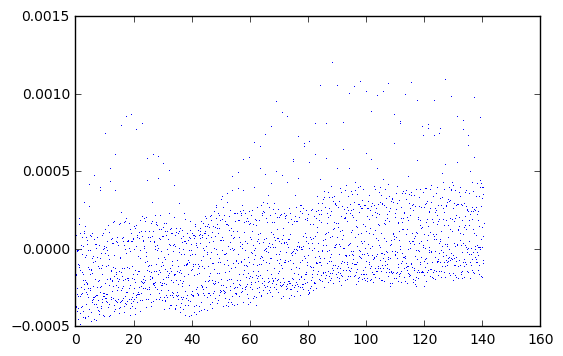

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
mean = run['a1'].mean()
ax.plot(run['Time'], (run['a1']-mean)/mean, ',')
#ax.set_xlim([0,20])

(0, 0.02)

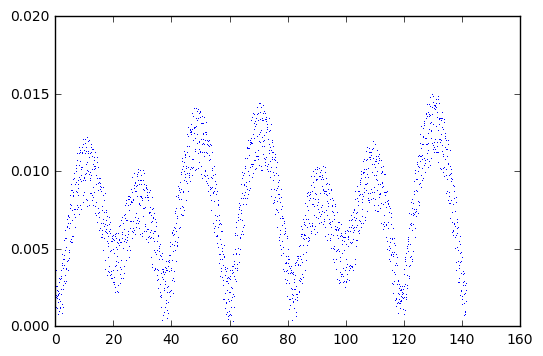

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(run['Time'], run['e3'], ',')
ax.set_ylim([0,0.02])

(0, 20)

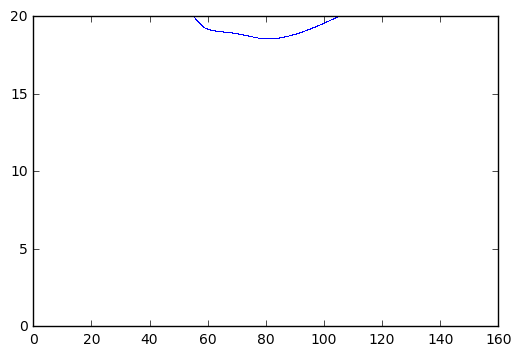

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(run['Time'], run['Lyapunov Time'], ',')
ax.set_ylim([0, 20])

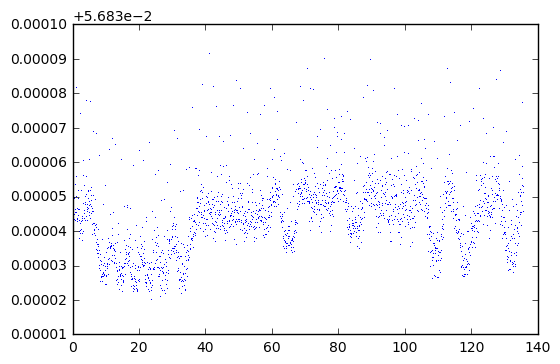

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(run['Time'], run['a1'], ',')
#ax.set_xlim([0,20])

In [217]:
dfnonres = df.loc[(df['Pratio21'] > 1.269) & (df['Pratio21'] < 1.271)]
simnonresids = dfnonres.index.values

In [187]:
sim_id = simnonresids[2]
system(sim_id)

[183,
 False,
 9590.244897448729,
 10000.0,
 1.4999999999999999e-05,
 0.021544346900299997,
 0.04215845920679021,
 0.00865613134987766,
 0.006031181910250666,
 -4.904101878502302,
 0.014265108440325384,
 -3.0197203190848136,
 0.5796889130474594,
 0.049415615293136345,
 0.010984740370857721,
 0.012915350483452711,
 -0.6611543892033798,
 0.0012638159117220927,
 -2.3579490506336263,
 -1.8889205086785934,
 0.054745354095975966,
 0.012808879272779024,
 0.01930673377195614,
 -0.5056582255337514,
 0.01708792129604345,
 0.09546657669605506,
 0.29359576538705234,
 0.0048577638025218669,
 0.7868459224700928]

In [153]:
columns = ['Sim_ID', 'Stable', 'Norbits_instability', 'Norbits', 'Mplanet', 'RH/a']
for i in ['1', '2', '3']:
    columns += ['a'+i, 'P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i]
columns += ['Rel_Eerr', 'integ_time']